In [1]:
sys.path.insert(0, './common')

import numpy as np
from collections import deque
import sys
import cartpole
import a2c_model

In [2]:
env = cartpole.CartPoleEnv()

CARTPOLE environment created.


In [40]:
import numpy as np
import torch

import env_interface
import model_interface
import plot


class A2C(model_interface.ModelInterface):
    def __init__(self, input_layer, output_layer, hidden_layer=256, lr=1e-4):
        self.actor = torch.nn.Sequential(
            torch.nn.Linear(input_layer, hidden_layer),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer, output_layer),
            torch.nn.Softmax(dim=1)
        )
        self.critic = torch.nn.Sequential(
            torch.nn.Linear(input_layer, hidden_layer),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer, 1),
        )

        self.loss_fn = torch.nn.MSELoss()
        self.input_layer = input_layer
        self.output_layer = output_layer
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr * 2)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr)
        self.set_train_params()
        self.reset_train_memory()

    def set_train_params(self, max_step=500, gamma=.9):
        self.max_step = max_step
        self.gamma = gamma

    def discount_rewards(self, rewards: np.ndarray):
        reversed_rewards = np.copy(rewards)[::-1]
        discounted_rewards = []
        for i, reward in enumerate(reversed_rewards):
            discounted_rewards.append(reward + (0 if i == 0 else reversed_rewards[i - 1]))
            reversed_rewards[i] = reward * self.gamma
            if i > 0:
                reversed_rewards[i] += reversed_rewards[i - 1] * self.gamma
        discounted_rewards = np.array(discounted_rewards[::-1])
        return discounted_rewards

    def get_advantages(self, values, masks, rewards):
        adv = np.zeros(len(values))
        for i in reversed(range(len(rewards))):
            next_value = 0
            if i + 1 < len(rewards):
                next_value = values[i + 1]
            adv[i] = rewards[i] + self.gamma * next_value * masks[i] - values[i]

        adv = np.array(adv)
        return (adv - np.mean(adv)) / (np.std(adv) + 1e-10)

    def update_model(self, states, actions, rewards):
        states_tensor = torch.Tensor(states)
        predictions = self.actor(states_tensor)
        discounted_rewards = torch.Tensor(self.discount_rewards(rewards))

        values = self.critic(states_tensor)
        critic_loss = 0.5 * torch.pow(values - discounted_rewards, 2).mean()
        self.update_critic(critic_loss)

        detached_values = values.detach().numpy()
        masks = np.ones_like(detached_values)
        masks[-1] = 0
        advantages = torch.Tensor(self.get_advantages(detached_values.flatten(), masks, rewards))
        actions = torch.Tensor(actions.reshape(-1, 1)).long()
        prob_batch = predictions.gather(dim=1,index=actions).squeeze()
        actor_loss = (advantages * -torch.log(prob_batch)).mean()
        self.update_actor(actor_loss)

        self.train_losses.append(actor_loss.item())

    def update_critic(self, loss):
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()

    def update_actor(self, loss):
        self.actor_optimizer.zero_grad()
        loss.backward()
        self.actor_optimizer.step()


    def train(self, env: env_interface.EnvInterface, epoch=1000, reset_memory=False, is_clearing_output=True):
        super().train(env, epoch, reset_memory)

        for i in range(epoch):
            timestep = 0
            state, is_done = env.reset()
            episode_reward = 0

            states = []
            actions = []
            rewards = []

            while timestep < self.max_step and not is_done:
                timestep += 1

                state_tensor = torch.Tensor(state)

                predictions = self.actor(state_tensor)
                values = self.critic(state_tensor)
                print(predictions, values)
                detached_predictions = predictions.detach().numpy().flatten()
                action_space = np.array(range(self.output_layer))
                action = np.random.choice(action_space, p=detached_predictions)

                next_state, reward, is_done = env.step(action)
                episode_reward += reward

                states.append(state[0])
                actions.append(action)
                rewards.append(reward)

                state = next_state

            states, actions, rewards = np.array(states), np.array(actions), np.array(rewards)
            self.update_model(states, actions, rewards)
            self.train_rewards.append(episode_reward)
            self.train_timesteps.append(timestep)
            plot.plot_res(self.train_rewards, f'A2C ({i + 1})', is_clearing_output)
            print(f'EPOCH: {i}, total reward: {episode_reward}, timestep: {timestep}')

        env.close()

    def test(self, env: env_interface.EnvInterface):
        state, is_done = env.reset()
        timestep = 0
        total_reward = 0
        while not is_done:
            timestep += 1
            predictions = self.actor(torch.Tensor(state)).detach().numpy()

            action = np.argmax(predictions)
            state, reward, is_done = env.step(action)
            total_reward += reward

        env.close()
        return total_reward, timestep


In [42]:
model = A2C(4, 2, 100, lr=1e-4)
save_path = './models/a2c-cartpole.pth'
model.set_model_save_path(save_path)

In [43]:
model.train(env, 500)

KeyboardInterrupt: 

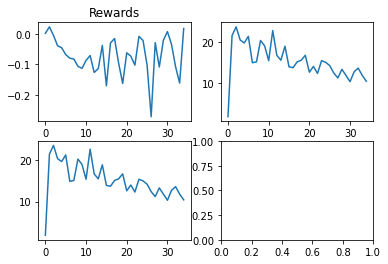

In [39]:
model.plot_train_memory()

In [ ]:
env = cartpole.CartPoleEnv()
model.test(env)